In [1]:
import hiive.mdptoolbox.mdp as mdp
import numpy as np
import time
import matplotlib.pyplot as plt
from statistics import mean
from scipy import sparse

In [486]:
# Frozen Lake Problem
# Modified from OpenAI Gym
# https://github.com/openai/gym/blob/a5a6ae6bc0a5cfc0ff1ce9be723d59593c165022/gym/envs/toy_text/frozen_lake.py
import sys
from contextlib import closing

import numpy as np
from io import StringIO

LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3


def generate_random_map(size=8, p=0.8):
    """Generates a random valid map (one that has a path from start to goal)
    :param size: size of each side of the grid
    :param p: probability that a tile is frozen
    """
    valid = False

    # DFS to check that it's a valid path.
    def is_valid(res):
        frontier, discovered = [], set()
        frontier.append((0, 0))
        while frontier:
            r, c = frontier.pop()
            if not (r, c) in discovered:
                discovered.add((r, c))
                directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]
                for x, y in directions:
                    r_new = r + x
                    c_new = c + y
                    if r_new < 0 or r_new >= size or c_new < 0 or c_new >= size:
                        continue
                    if res[r_new][c_new] == 'G':
                        return True
                    if (res[r_new][c_new] != 'H'):
                        frontier.append((r_new, c_new))
        return False

    while not valid:
        p = min(1, p)
        res = np.random.choice(['F', 'H'], (size, size), p=[p, 1-p])
        res[0][0] = 'S'
        res[-1][-1] = 'G'
        valid = is_valid(res)
    return ["".join(x) for x in res]

def generate_transition_matrix(lake):
    size = np.size(lake)
    T = np.zeros((4,int(size*size),int(size*size)))
    for a in range(4):
        for row in range(size):
            for col in range(size):
                letter = lake[row][col]
                if letter in 'GH':
                    T[a][row*size + col][row*size + col] = 1
                else:
                    if a == 0:
                        T[a][row*size + col][max((row-1)*size + col,0)] += 1./3. #UP
                        T[a][row*size + col][max(row*size + (col-1),0)] += 1./3.           #LEFT
                        T[a][row*size + col][min((row+1)*size + col,size*size-1)] += 1./3. #DOWN
                    elif a == 1:
                        T[a][row*size + col][max(row*size + (col-1),0)] += 1./3. #LEFT
                        T[a][row*size + col][min((row+1)*size + col,size*size-1)] += 1./3.        #DOWN
                        T[a][row*size + col][min(row*size + (col+1),size*size-1)] += 1./3. #RIGHT
                    elif a == 2:
                        T[a][row*size + col][min((row+1)*size + col,size*size-1)] += 1./3. #DOWN
                        T[a][row*size + col][min(row*size + (col+1),size*size-1)] += 1./3.           #RIGHT
                        T[a][row*size + col][max((row-1)*size + col,0)] += 1./3. #UP
                    else:
                        T[a][row*size + col][min(row*size + (col+1),size*size-1)] += 1./3. #RIGHT
                        T[a][row*size + col][max((row-1)*size + col,0)] += 1./3.           #UP
                        T[a][row*size + col][max(row*size + (col-1),0)] += 1./3. #LEFT
                        
    Tsparse=[]
    Tsparse.append(sparse.csr_matrix(T[0]))
    Tsparse.append(sparse.csr_matrix(T[1]))
    Tsparse.append(sparse.csr_matrix(T[2]))
    Tsparse.append(sparse.csr_matrix(T[3]))
    
    return Tsparse

def generate_reward_matrix(lake):
    size = np.size(lake)
    R = np.zeros((4,int(size*size),int(size*size)))
    for row in range(size):
        for col in range(size):
            letter = lake[row][col]
            if letter in 'G':
                R[0][row*size + col][row*size + col] = 1
                R[1][row*size + col][row*size + col] = 1
                R[2][row*size + col][row*size + col] = 1
                R[3][row*size + col][row*size + col] = 1
                
    Rsparse=[]
    Rsparse.append(sparse.csr_matrix(R[0]))
    Rsparse.append(sparse.csr_matrix(R[1]))
    Rsparse.append(sparse.csr_matrix(R[2]))
    Rsparse.append(sparse.csr_matrix(R[3]))
    
    return Rsparse

In [552]:
map_size = 8
np.random.seed(1)
lake = generate_random_map(size=map_size)
T = generate_transition_matrix(lake)
R = generate_reward_matrix(lake)

In [547]:
frzL = mdp.ValueIteration(T,R,0.99)
frzL.run()
policy = np.asarray(frzL.policy).reshape(map_size,map_size)
value = np.asarray(frzL.V).reshape(map_size,map_size)

In [548]:
for i in range(0,len(policy)):
    for j in range(0,len(policy)):
        col = value[i][j]
        print("{col:0.2f}".format(col=col),end="\t")
    print()

50.07	51.17	52.20	51.88	49.87	49.16	49.04	49.37	
50.50	52.77	55.15	54.92	34.58	0.00	45.88	47.99	
50.19	53.59	59.43	59.41	0.00	0.00	41.98	43.89	
0.00	0.00	65.55	65.67	43.24	0.00	37.46	43.01	
0.00	48.61	73.53	74.03	65.37	0.00	28.53	48.99	
0.00	73.76	83.23	85.15	80.82	57.96	0.00	76.91	
87.59	91.70	93.29	93.98	94.38	94.83	95.52	96.47	
96.84	96.98	97.04	97.10	97.20	97.46	98.16	99.99	


In [501]:
for i in range(0,len(policy)):
    for j in range(0,len(policy)):
        col = policy[i][j]
        if lake[i][j] == "H":
            print("  X  ",end="\t")
        elif lake[i][j] == "G":
            print("GOAL",end="\t")
        elif col == 0:
            print("LEFT",end="\t")
        elif col == 1:
            print("DOWN",end="\t")
        elif col == 2:
            print("RIGHT",end="\t")
        else:
            print("UP".format(col=col),end="\t")
    print()

print()
for row in lake:
    for letter in row:
        print("  " + letter + "  ",end="\t")
    print()

DOWN	DOWN	DOWN	LEFT	UP	UP	UP	UP	
RIGHT	RIGHT	DOWN	LEFT	LEFT	  X  	RIGHT	UP	
UP	UP	RIGHT	LEFT	  X  	  X  	RIGHT	LEFT	
  X  	  X  	RIGHT	LEFT	LEFT	  X  	RIGHT	LEFT	
  X  	DOWN	RIGHT	LEFT	LEFT	  X  	RIGHT	LEFT	
  X  	RIGHT	DOWN	DOWN	LEFT	LEFT	  X  	RIGHT	
DOWN	DOWN	DOWN	DOWN	DOWN	DOWN	DOWN	DOWN	
DOWN	DOWN	DOWN	DOWN	DOWN	DOWN	DOWN	GOAL	

  S  	  F  	  F  	  F  	  F  	  F  	  F  	  F  	
  F  	  F  	  F  	  F  	  F  	  H  	  F  	  F  	
  F  	  F  	  F  	  F  	  H  	  H  	  F  	  F  	
  H  	  H  	  F  	  F  	  F  	  H  	  F  	  F  	
  H  	  F  	  F  	  F  	  F  	  H  	  F  	  F  	
  H  	  F  	  F  	  F  	  F  	  F  	  H  	  F  	
  F  	  F  	  F  	  F  	  F  	  F  	  F  	  F  	
  F  	  F  	  F  	  F  	  F  	  F  	  F  	  G  	


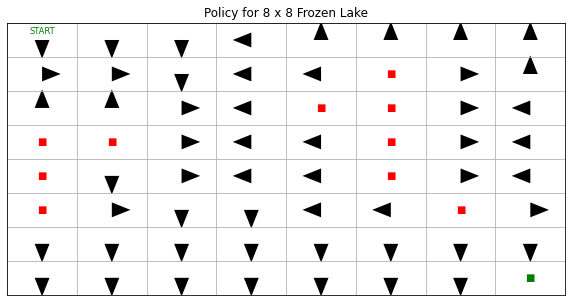

In [502]:
x,y = np.meshgrid(np.linspace(1,len(policy),len(policy)),np.linspace(1,len(policy),len(policy)))
u,v = np.meshgrid(np.linspace(1,len(policy),len(policy)),np.linspace(1,len(policy),len(policy)))


for i in range(0,len(policy)):
    for j in range(0,len(policy)):
        n = len(policy)-1
        col = policy[i][j]
        if lake[i][j] == "H":
            plt.text(j+1,i+1,"■",color="red",horizontalalignment='center',verticalalignment='center')
            u[i][j] = 0
            v[i][j] = 0
        elif lake[i][j] == "G":
            plt.text(j+1,i+1,"■",color="green",horizontalalignment='center',verticalalignment='center')
            u[i][j] = 0
            v[i][j] = 0
        elif col == 0:
            u[i][j] = -1
            v[i][j] = 0
        elif col == 1:
            u[i][j] = 0
            v[i][j] = -1
        elif col == 2:
            u[i][j] = 1
            v[i][j] = 0
        else:
            u[i][j] = 0
            v[i][j] = 1
    print()


plt.text(1,0.6,"START",color="green",horizontalalignment='center',verticalalignment='top',fontsize='small')
#plt.imshow(value,cmap="Blues")
plt.quiver(x,y,u,v,scale=30,headwidth=200,headlength=250,headaxislength=250,width=0.0005)
plt.grid(True,which='major')
plt.xticks(ticks=np.linspace(0.5,8.5,9),labels=None)
plt.yticks(ticks=np.linspace(0.5,8.5,9),labels=None)
plt.ylim(8.5,0.5)
plt.xlim(0.5,8.5)
plt.tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)
plt.title("Policy for 8 x 8 Frozen Lake")
plt.savefig("Images/FrozenLake8x8_policy.png")
plt.show()

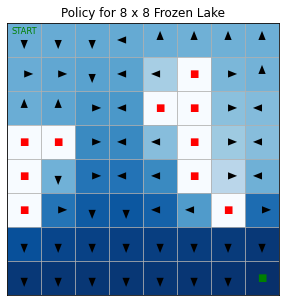

In [521]:
x,y = np.meshgrid(np.linspace(1,len(policy),len(policy)),np.linspace(1,len(policy),len(policy)))
u,v = np.meshgrid(np.linspace(1,len(policy),len(policy)),np.linspace(1,len(policy),len(policy)))


for i in range(0,len(policy)):
    for j in range(0,len(policy)):
        n = len(policy)-1
        col = policy[i][j]
        if lake[i][j] == "H":
            plt.text(j+1,i+1,"■",color="red",horizontalalignment='center',verticalalignment='center')
            u[i][j] = 0
            v[i][j] = 0
        elif lake[i][j] == "G":
            plt.text(j+1,i+1,"■",color="green",horizontalalignment='center',verticalalignment='center')
            u[i][j] = 0
            v[i][j] = 0
        elif col == 0:
            u[i][j] = -1
            v[i][j] = 0
        elif col == 1:
            u[i][j] = 0
            v[i][j] = -1
        elif col == 2:
            u[i][j] = 1
            v[i][j] = 0
        else:
            u[i][j] = 0
            v[i][j] = 1
    print()

value = np.asarray(frzL.V)
    
for i in range(0,8):
    value = np.insert(value,0,0)

for i in range(0,9):
    value = np.insert(value,8*i+i,0)
    
value = value.reshape(map_size+1,map_size+1)
plt.imshow(value,cmap="Blues")
plt.text(1,0.6,"START",color="green",horizontalalignment='center',verticalalignment='top',fontsize='small')
plt.quiver(x,y,u,v,scale=30,headwidth=200,headlength=250,headaxislength=250,width=0.0005)
plt.grid(True,which='major')
plt.xticks(ticks=np.linspace(0.5,8.5,9),labels=None)
plt.yticks(ticks=np.linspace(0.5,8.5,9),labels=None)
plt.ylim(8.5,0.5)
plt.xlim(0.5,8.5)
plt.tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)
plt.title("Policy for 8 x 8 Frozen Lake")
plt.savefig("Images/FrozenLake8x8_policy_color.png")
plt.show()

In [557]:
frzL = mdp.ValueIteration(T,R,0.1,epsilon=0.00001)
frzL.run()
policy = np.asarray(frzL.policy).reshape(map_size,map_size)
value = np.asarray(frzL.V).reshape(map_size,map_size)

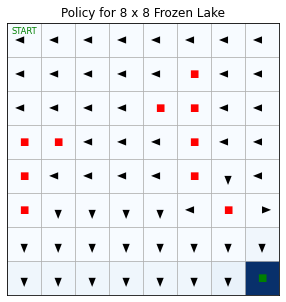

In [558]:
x,y = np.meshgrid(np.linspace(1,len(policy),len(policy)),np.linspace(1,len(policy),len(policy)))
u,v = np.meshgrid(np.linspace(1,len(policy),len(policy)),np.linspace(1,len(policy),len(policy)))


for i in range(0,len(policy)):
    for j in range(0,len(policy)):
        n = len(policy)-1
        col = policy[i][j]
        if lake[i][j] == "H":
            plt.text(j+1,i+1,"■",color="red",horizontalalignment='center',verticalalignment='center')
            u[i][j] = 0
            v[i][j] = 0
        elif lake[i][j] == "G":
            plt.text(j+1,i+1,"■",color="green",horizontalalignment='center',verticalalignment='center')
            u[i][j] = 0
            v[i][j] = 0
        elif col == 0:
            u[i][j] = -1
            v[i][j] = 0
        elif col == 1:
            u[i][j] = 0
            v[i][j] = -1
        elif col == 2:
            u[i][j] = 1
            v[i][j] = 0
        else:
            u[i][j] = 0
            v[i][j] = 1
    print()

value = np.asarray(frzL.V)
    
for i in range(0,8):
    value = np.insert(value,0,0)

for i in range(0,9):
    value = np.insert(value,8*i+i,0)
    
value = value.reshape(map_size+1,map_size+1)
plt.imshow(value,cmap="Blues")
plt.text(1,0.6,"START",color="green",horizontalalignment='center',verticalalignment='top',fontsize='small')
plt.quiver(x,y,u,v,scale=30,headwidth=200,headlength=250,headaxislength=250,width=0.0005)
plt.grid(True,which='major')
plt.xticks(ticks=np.linspace(0.5,8.5,9),labels=None)
plt.yticks(ticks=np.linspace(0.5,8.5,9),labels=None)
plt.ylim(8.5,0.5)
plt.xlim(0.5,8.5)
plt.tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)
plt.title("Policy for 8 x 8 Frozen Lake")
plt.savefig("Images/FrozenLake8x8_policy_color_low_gamma.png")
plt.show()

In [549]:
policy = frzL.policy

In [525]:
map_size = 8
np.random.seed(1)
lake = generate_random_map(size=map_size)
T = generate_transition_matrix(lake)
R = generate_reward_matrix(lake)

In [550]:
v0_pi = []
v0_vi = []
iters_pi = []
iters_vi = []
iters_opt_vi = []
times_pi = []
times_vi = []
same_policy = []

gammas = np.linspace(0.8,0.99)
for gamma in gammas:
    frzL = mdp.PolicyIteration(T,R,gamma,eval_type=1)
    frzL.run()
    v0_pi.append(frzL.run_stats[-1].get('Mean V')/frzL.run_stats[-1].get('Max V'))
    iters_pi.append(frzL.iter)
    times_pi.append(frzL.time)
    #uncomment the line below to see if PolicyIteration produces same results as Value Iteration (currently shows difference between gamma = 0.99 for ValueIteration)
    #policy = frzL.policy
    
    frzL = mdp.ValueIteration(T,R,gamma)
    frzL.run()
    v0_vi.append(frzL.run_stats[-1].get('Mean V')/frzL.run_stats[-1].get('Max V'))
    iters_vi.append(frzL.iter)
    iters_opt_vi.append(frzL.p_cumulative[-1][0])
    times_vi.append(frzL.time)
    if (frzL.policy == policy):
        same_policy.append(True)
    else:
        same_policy.append(False)

In [551]:
same_policy

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True]

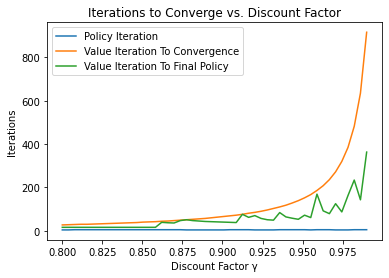

In [9]:
plt.plot(gammas,iters_pi,label="Policy Iteration")
plt.plot(gammas,iters_vi,label="Value Iteration To Convergence")
plt.plot(gammas,iters_opt_vi,label="Value Iteration To Final Policy")
plt.legend()
plt.title("Iterations to Converge vs. Discount Factor")
plt.xlabel("Discount Factor γ")
plt.ylabel("Iterations")
plt.savefig("Images/FrozenLake8x8_gamma_iterations.png")
plt.show()

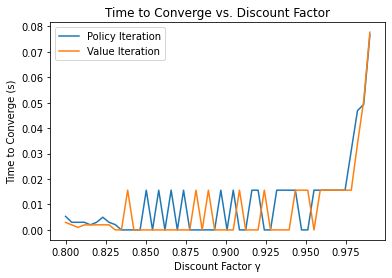

In [31]:
plt.plot(gammas,times_pi,label="Policy Iteration")
plt.plot(gammas,times_vi,label="Value Iteration")
plt.legend()
plt.title("Time to Converge vs. Discount Factor")
plt.xlabel("Discount Factor γ")
plt.ylabel("Time to Converge (s)")
plt.savefig("Images/FrozenLake8x8_gamma_time.png")
plt.show()

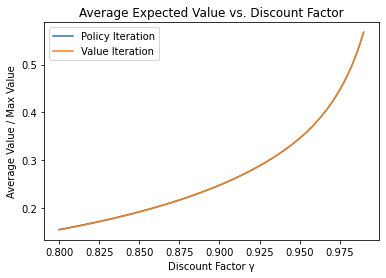

In [95]:
plt.plot(gammas,v0_pi,label="Policy Iteration")
plt.plot(gammas,v0_vi,label="Value Iteration")
plt.legend()
plt.title("Average Expected Value vs. Discount Factor")
plt.xlabel("Discount Factor γ")
plt.ylabel("Average Value / Max Value")
plt.savefig("Images/FrozenLake8x8_gamma_averageVal.png")
plt.show()

In [17]:
v0_vi = []
iters_vi = []
iters_opt_vi = []

epsilon = np.logspace(-3,1)
for ep in epsilon: 
    frzL = mdp.ValueIteration(T,R,0.99,epsilon=ep)
    frzL.run()
    v0_vi.append(frzL.run_stats[-1].get('Mean V')/frzL.run_stats[-1].get('Max V'))
    iters_vi.append(frzL.iter)
    iters_opt_vi.append(frzL.p_cumulative[-1][0])

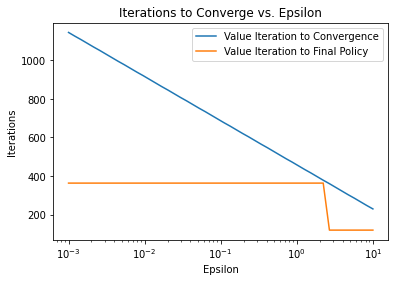

In [18]:
plt.plot(epsilon,iters_vi,label="Value Iteration to Convergence")
plt.plot(epsilon,iters_opt_vi,label="Value Iteration to Final Policy")
plt.legend()
plt.xscale('log')
plt.title("Iterations to Converge vs. Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Iterations")
plt.savefig("Images/FrozenLake8x8_epsilon_iterations.png")
plt.show()

In [24]:
#The drop in iterations occurs at the 41st value of epsilon
epsilon[41]

2.2229964825261934

In [26]:
v0_vi_opt = []
iters_vi_opt = []

epsilon = np.logspace(-3,1)
for ep in epsilon: 
    frzL = mdp.ValueIteration(T,R,0.99,epsilon=epsilon[41])
    frzL.run()
    v0_vi_opt.append(frzL.run_stats[-1].get('Mean V')/frzL.run_stats[-1].get('Max V'))
    iters_vi_opt.append(frzL.iter)

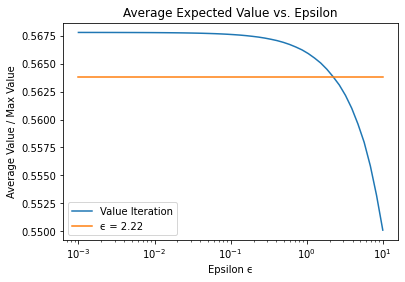

In [29]:
plt.plot(epsilon,v0_vi,label="Value Iteration")
plt.plot(epsilon,v0_vi_opt,label="ϵ = {epsilon:0.2f}".format(epsilon=epsilon[41]))
plt.legend()
plt.xscale('log')
plt.title("Average Expected Value vs. Epsilon")
plt.xlabel("Epsilon ϵ")
plt.ylabel("Average Value / Max Value")
plt.savefig("Images/FrozenLake8x8_epsilon_averageVal.png")
plt.show()

In [489]:
#Q-learning time!
#I don't think I should be excited


frzL = mdp.QLearning(T,R,0.9,n_iter=1000000000)
t0 = time.perf_counter()
frzL.run()
t1 = time.perf_counter()
print("Mean V / Max V: " + str(frzL.run_stats[-1].get('Mean V')/frzL.run_stats[-1].get('Max V')))
print(str(t1-t0))

Mean V / Max V: 0.21484639709908063
78821.41211600002


In [492]:
v0_ql = []
for i in range(0,len(frzL.run_stats)):
    v0_ql.append(frzL.run_stats[i].get('Mean V')/frzL.run_stats[i].get('Max V'))

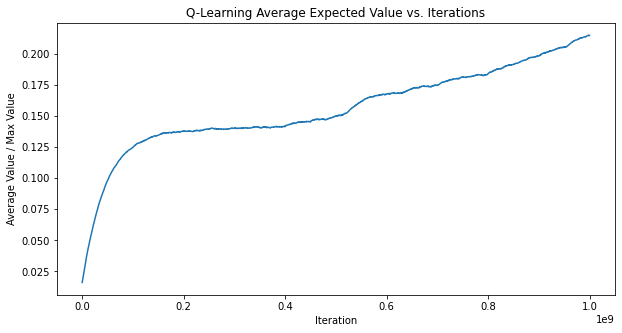

In [497]:
plt.plot(range(1,1000000001,int(1000000000/10000)),v0_ql)
plt.title("Q-Learning Average Expected Value vs. Iterations")
plt.xlabel("Iteration")
plt.ylabel("Average Value / Max Value")
plt.savefig("Images/FrozenLake8x8_ql_iteration_value.png")
plt.show()

In [529]:
map_size = 32
np.random.seed(1)
lake = generate_random_map(size=map_size)
T = generate_transition_matrix(lake)
R = generate_reward_matrix(lake)

frzL = mdp.ValueIteration(T,R,0.99,epsilon=0.0001)
frzL.run()
policy = np.asarray(frzL.policy).reshape(map_size,map_size)
value = np.asarray(frzL.V).reshape(map_size,map_size)

In [197]:
for i in range(0,len(policy)):
    for j in range(0,len(policy)):
        col = value[i][j]
        print("{col:0.2f}".format(col=col),end="\t")
    print()

0.22	0.23	0.23	0.23	0.22	0.22	0.21	0.21	0.21	0.21	0.21	0.21	0.20	0.00	0.21	0.40	0.48	0.52	0.51	0.42	0.00	0.00	0.22	0.22	0.00	0.00	0.24	0.23	0.22	0.00	0.20	0.19	
0.00	0.24	0.24	0.24	0.15	0.00	0.12	0.14	0.00	0.13	0.17	0.18	0.17	0.13	0.00	0.52	0.52	0.59	0.60	0.55	0.44	0.22	0.22	0.24	0.27	0.28	0.28	0.24	0.21	0.18	0.18	0.17	
0.14	0.25	0.26	0.26	0.00	0.11	0.00	0.08	0.03	0.00	0.11	0.10	0.00	0.24	0.58	0.65	0.00	0.66	0.67	0.63	0.56	0.00	0.16	0.00	0.30	0.32	0.31	0.00	0.12	0.16	0.15	0.10	
0.00	0.26	0.27	0.30	0.37	0.33	0.00	0.08	0.00	0.08	0.06	0.00	0.30	0.00	0.88	0.87	0.00	0.75	0.73	0.69	0.63	0.00	0.25	0.19	0.33	0.34	0.35	0.29	0.00	0.16	0.10	0.00	
0.22	0.27	0.24	0.00	0.48	0.52	0.00	0.17	0.00	0.17	0.00	0.30	0.92	1.18	1.22	1.11	0.98	0.87	0.79	0.72	0.65	0.54	0.42	0.00	0.35	0.36	0.41	0.53	0.52	0.23	0.00	0.00	
0.38	0.32	0.18	0.00	0.57	0.77	0.88	0.44	0.29	0.43	0.14	0.00	1.31	1.44	1.40	1.15	0.99	0.87	0.78	0.70	0.63	0.56	0.48	0.41	0.36	0.00	0.35	0.66	0.83	0.00	0.29	0.30	
0.63	0.31	0.00	0.00	0.48	0.89	1.44

In [198]:
for i in range(0,len(policy)):
    for j in range(0,len(policy)):
        col = policy[i][j]
        if lake[i][j] == "H":
            print("  X  ",end="\t")
        elif lake[i][j] == "G":
            print("GOAL",end="\t")
        elif col == 0:
            print("LEFT",end="\t")
        elif col == 1:
            print("DOWN",end="\t")
        elif col == 2:
            print("RIGHT",end="\t")
        else:
            print("UP".format(col=col),end="\t")
    print()

print()
for row in lake:
    for letter in row:
        print("  " + letter + "  ",end="\t")
    print()

UP	DOWN	DOWN	LEFT	UP	UP	UP	UP	UP	UP	UP	UP	LEFT	  X  	RIGHT	RIGHT	DOWN	DOWN	DOWN	LEFT	  X  	  X  	RIGHT	LEFT	  X  	  X  	RIGHT	LEFT	LEFT	  X  	RIGHT	LEFT	
  X  	RIGHT	DOWN	LEFT	LEFT	  X  	RIGHT	LEFT	  X  	RIGHT	UP	UP	UP	LEFT	  X  	RIGHT	UP	DOWN	DOWN	DOWN	DOWN	DOWN	UP	UP	DOWN	DOWN	LEFT	UP	UP	DOWN	UP	UP	
DOWN	RIGHT	DOWN	LEFT	  X  	LEFT	  X  	RIGHT	LEFT	  X  	RIGHT	LEFT	  X  	RIGHT	DOWN	LEFT	  X  	RIGHT	DOWN	DOWN	LEFT	  X  	LEFT	  X  	RIGHT	DOWN	LEFT	  X  	RIGHT	RIGHT	UP	LEFT	
  X  	RIGHT	UP	UP	DOWN	LEFT	  X  	LEFT	  X  	DOWN	LEFT	  X  	LEFT	  X  	RIGHT	LEFT	  X  	RIGHT	DOWN	LEFT	LEFT	  X  	RIGHT	DOWN	RIGHT	DOWN	LEFT	LEFT	  X  	RIGHT	LEFT	  X  	
DOWN	RIGHT	LEFT	  X  	RIGHT	LEFT	  X  	LEFT	  X  	LEFT	  X  	DOWN	DOWN	DOWN	DOWN	DOWN	DOWN	DOWN	LEFT	LEFT	LEFT	DOWN	LEFT	  X  	RIGHT	UP	DOWN	DOWN	DOWN	LEFT	  X  	  X  	
RIGHT	LEFT	LEFT	  X  	RIGHT	DOWN	DOWN	UP	DOWN	LEFT	LEFT	  X  	RIGHT	DOWN	LEFT	UP	UP	UP	UP	UP	UP	LEFT	LEFT	DOWN	LEFT	  X  	RIGHT	RIGHT	LEFT	  X  	DOWN	DOWN	
RIGHT	LEFT	  X  	  X  	RI

  H  	  F  	  H  	  F  	  H  	  F  	  F  	  H  	  F  	  H  	  H  	  F  	  F  	  H  	  F  	  F  	  H  	  H  	  F  	  H  	  F  	  F  	  F  	  F  	  F  	  H  	  F  	  F  	  F  	  F  	  F  	  F  	
  F  	  F  	  F  	  F  	  F  	  F  	  F  	  F  	  F  	  F  	  F  	  F  	  F  	  H  	  F  	  H  	  F  	  F  	  H  	  F  	  F  	  F  	  F  	  F  	  F  	  F  	  F  	  H  	  F  	  F  	  F  	  H  	
  H  	  F  	  F  	  H  	  F  	  H  	  F  	  F  	  F  	  F  	  F  	  F  	  H  	  F  	  F  	  F  	  F  	  F  	  F  	  F  	  F  	  F  	  F  	  F  	  F  	  F  	  F  	  F  	  F  	  F  	  F  	  F  	
  F  	  F  	  F  	  H  	  F  	  F  	  F  	  F  	  F  	  F  	  F  	  H  	  H  	  F  	  F  	  F  	  F  	  F  	  H  	  F  	  F  	  F  	  F  	  H  	  H  	  F  	  F  	  F  	  F  	  F  	  F  	  F  	
  H  	  F  	  F  	  H  	  F  	  H  	  F  	  F  	  F  	  F  	  F  	  F  	  F  	  F  	  F  	  F  	  F  	  F  	  F  	  F  	  F  	  F  	  F  	  F  	  F  	  F  	  F  	  F  	  F  	  F  	  H  	  F  	
  F  	  F  	  H  	  F  	  F  	  H  

In [530]:
v0_pi = []
v0_vi = []
iters_pi = []
iters_vi = []
iters_opt_vi = []
times_pi = []
times_vi = []
same_policy = []

gammas = np.linspace(0.8,0.99)
for gamma in gammas:
    frzL = mdp.PolicyIteration(T,R,gamma,eval_type=1)
    frzL.run()
    v0_pi.append(frzL.run_stats[-1].get('Mean V')/frzL.run_stats[-1].get('Max V'))
    iters_pi.append(frzL.iter)
    times_pi.append(frzL.time)
    policy = frzL.policy
    
    frzL = mdp.ValueIteration(T,R,gamma,epsilon=0.0001)
    frzL.run()
    v0_vi.append(frzL.run_stats[-1].get('Mean V')/frzL.run_stats[-1].get('Max V'))
    iters_vi.append(frzL.iter)
    iters_opt_vi.append(frzL.p_cumulative[-1][0])
    times_vi.append(frzL.time)
    if (frzL.policy == policy):
        same_policy.append(True)
    else:
        same_policy.append(False)

In [531]:
same_policy

[False,
 False,
 False,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

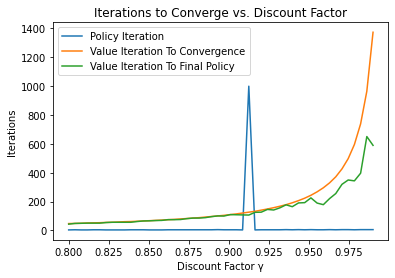

In [200]:
plt.plot(gammas,iters_pi,label="Policy Iteration")
plt.plot(gammas,iters_vi,label="Value Iteration To Convergence")
plt.plot(gammas,iters_opt_vi,label="Value Iteration To Final Policy")
plt.legend()
plt.title("Iterations to Converge vs. Discount Factor")
plt.xlabel("Discount Factor γ")
plt.ylabel("Iterations")
plt.savefig("Images/FrozenLake32x32_gamma_iterations.png")
plt.show()

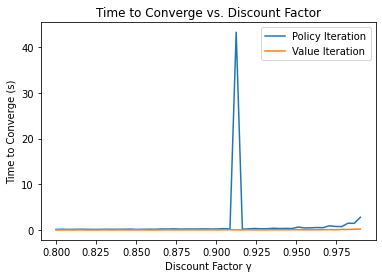

In [201]:
plt.plot(gammas,times_pi,label="Policy Iteration")
plt.plot(gammas,times_vi,label="Value Iteration")
plt.legend()
plt.title("Time to Converge vs. Discount Factor")
plt.xlabel("Discount Factor γ")
plt.ylabel("Time to Converge (s)")
plt.savefig("Images/FrozenLake32x32_gamma_time.png")
plt.show()

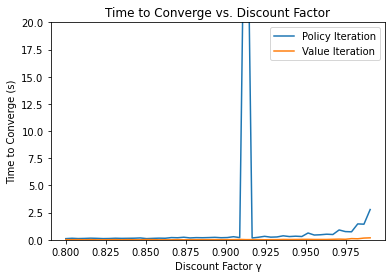

In [202]:
plt.plot(gammas,times_pi,label="Policy Iteration")
plt.plot(gammas,times_vi,label="Value Iteration")
plt.legend()
plt.ylim(0,20)
plt.title("Time to Converge vs. Discount Factor")
plt.xlabel("Discount Factor γ")
plt.ylabel("Time to Converge (s)")
plt.savefig("Images/FrozenLake32x32_gamma_time_zoom.png")
plt.show()

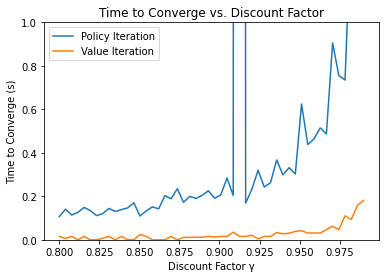

In [203]:
plt.plot(gammas,times_pi,label="Policy Iteration")
plt.plot(gammas,times_vi,label="Value Iteration")
plt.legend()
plt.ylim(0,1)
plt.title("Time to Converge vs. Discount Factor")
plt.xlabel("Discount Factor γ")
plt.ylabel("Time to Converge (s)")
plt.savefig("Images/FrozenLake32x32_gamma_time_zoom_zoom.png")
plt.show()

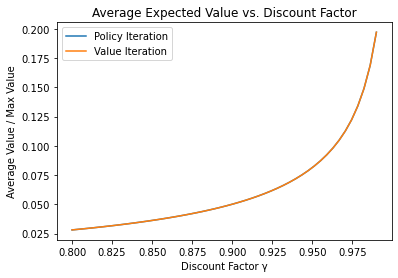

In [204]:
plt.plot(gammas,v0_pi,label="Policy Iteration")
plt.plot(gammas,v0_vi,label="Value Iteration")
plt.legend()
plt.title("Average Expected Value vs. Discount Factor")
plt.xlabel("Discount Factor γ")
plt.ylabel("Average Value / Max Value")
plt.savefig("Images/FrozenLake32x32_gamma_averageVal.png")
plt.show()

In [206]:
v0_vi = []
vmax_vi=[]
iters_vi = []
iters_opt_vi = []

epsilon = np.logspace(-5,1)
for ep in epsilon: 
    frzL = mdp.ValueIteration(T,R,0.99,epsilon=ep)
    frzL.run()
    v0_vi.append(frzL.run_stats[-1].get('Mean V')/frzL.run_stats[-1].get('Max V'))
    vmax_vi.append(frzL.run_stats[-1].get('Max V'))
    iters_vi.append(frzL.iter)
    iters_opt_vi.append(frzL.p_cumulative[-1][0])

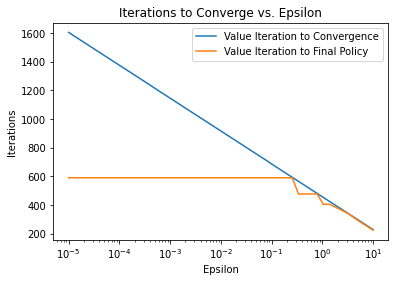

In [207]:
plt.plot(epsilon,iters_vi,label="Value Iteration to Convergence")
plt.plot(epsilon,iters_opt_vi,label="Value Iteration to Final Policy")
plt.legend()
plt.xscale('log')
plt.title("Iterations to Converge vs. Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Iterations")
plt.savefig("Images/FrozenLake32x32_epsilon_iterations.png")
plt.show()

In [219]:
iters_opt_vi[36]
epsilon[36]

0.2559547922699533

In [222]:
v0_opt = []
vmax_opt = []
iters_opt = []

epsilon = np.logspace(-5,1)
for ep in epsilon: 
    frzL = mdp.ValueIteration(T,R,0.99,epsilon=epsilon[36])
    frzL.run()
    v0_opt.append(frzL.run_stats[-1].get('Mean V')/frzL.run_stats[-1].get('Max V'))
    vmax_opt.append(frzL.run_stats[-1].get('Max V'))
    iters_opt.append(frzL.iter)

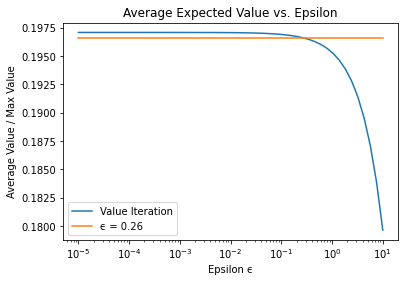

In [224]:
plt.plot(epsilon,v0_vi,label="Value Iteration")
plt.plot(epsilon,v0_opt,label="ϵ = {epsilon:0.2f}".format(epsilon=epsilon[36]))
plt.legend()
plt.xscale('log')
plt.title("Average Expected Value vs. Epsilon")
plt.xlabel("Epsilon ϵ")
plt.ylabel("Average Value / Max Value")
plt.savefig("Images/FrozenLake32x32_epsilon_averageVal.png")
plt.show()

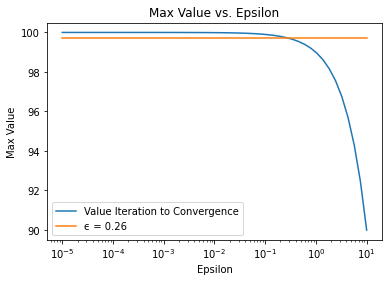

In [226]:
plt.plot(epsilon,vmax_vi,label="Value Iteration to Convergence")
plt.plot(epsilon,vmax_opt,label="ϵ = {epsilon:0.2f}".format(epsilon=epsilon[36]))
plt.legend()
plt.xscale('log')
plt.title("Max Value vs. Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Max Value")
plt.savefig("Images/FrozenLake32x32_epsilon_max_value.png")
plt.show()

In [405]:
v0_vi = []
vmax_vi=[]
iters_vi = []
iters_opt_vi = []

epsilon = np.logspace(0,7)
for ep in epsilon: 
    frzL = mdp.ValueIteration(T,R,0.9999,epsilon=ep)
    frzL.run()
    v0_vi.append(frzL.run_stats[-1].get('Mean V')/frzL.run_stats[-1].get('Max V'))
    vmax_vi.append(frzL.run_stats[-1].get('Max V'))
    iters_vi.append(frzL.iter)
    iters_opt_vi.append(frzL.p_cumulative[-1][0])

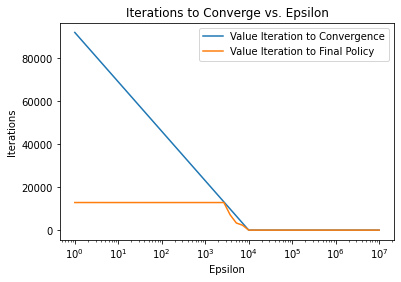

In [412]:
plt.plot(epsilon,iters_vi,label="Value Iteration to Convergence")
plt.plot(epsilon,iters_opt_vi,label="Value Iteration to Final Policy")
plt.legend()
plt.xscale('log')
plt.title("Iterations to Converge vs. Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Iterations")
plt.savefig("Images/FrozenLake32x32_epsilon_iterations_gamma09999.png")
plt.show()

In [426]:
iters_opt_vi[24]
epsilon[24]

2682.6957952797247

In [432]:
v0_vi_opt = []
vmax_vi_opt=[]
iters_vi_opt = []
#iters_opt_vi = []

for ep in epsilon: 
    frzL = mdp.ValueIteration(T,R,0.9999,epsilon=epsilon[24])
    frzL.run()
    v0_vi_opt.append(frzL.run_stats[-1].get('Mean V')/frzL.run_stats[-1].get('Max V'))
    vmax_vi_opt.append(frzL.run_stats[-1].get('Max V'))
    iters_vi_opt.append(frzL.iter)
    #iters_opt_vi.append(frzL.p_cumulative[-1][0])

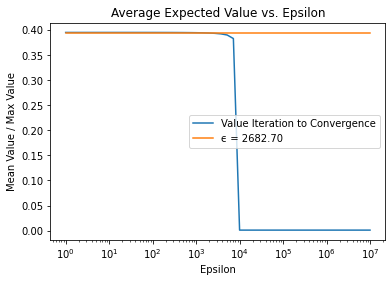

In [433]:
plt.plot(epsilon,v0_vi,label="Value Iteration to Convergence")
plt.plot(epsilon,v0_vi_opt,label="ϵ = {epsilon:0.2f}".format(epsilon=epsilon[24]))
plt.legend()
plt.xscale('log')
plt.title("Average Expected Value vs. Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Mean Value / Max Value")
plt.savefig("Images/FrozenLake32x32_epsilon_value_gamma09999.png")
plt.show()

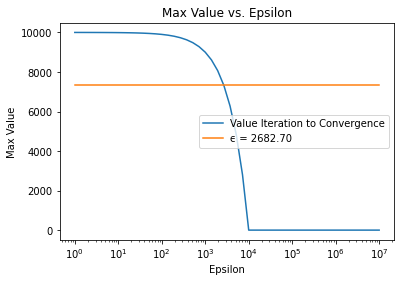

In [434]:
plt.plot(epsilon,vmax_vi,label="Value Iteration to Convergence")
plt.plot(epsilon,vmax_vi_opt,label="ϵ = {epsilon:0.2f}".format(epsilon=epsilon[24]))
plt.legend()
plt.xscale('log')
plt.title("Max Value vs. Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Max Value")
plt.savefig("Images/FrozenLake32x32_epsilon_max_value_gamma09999.png")
plt.show()

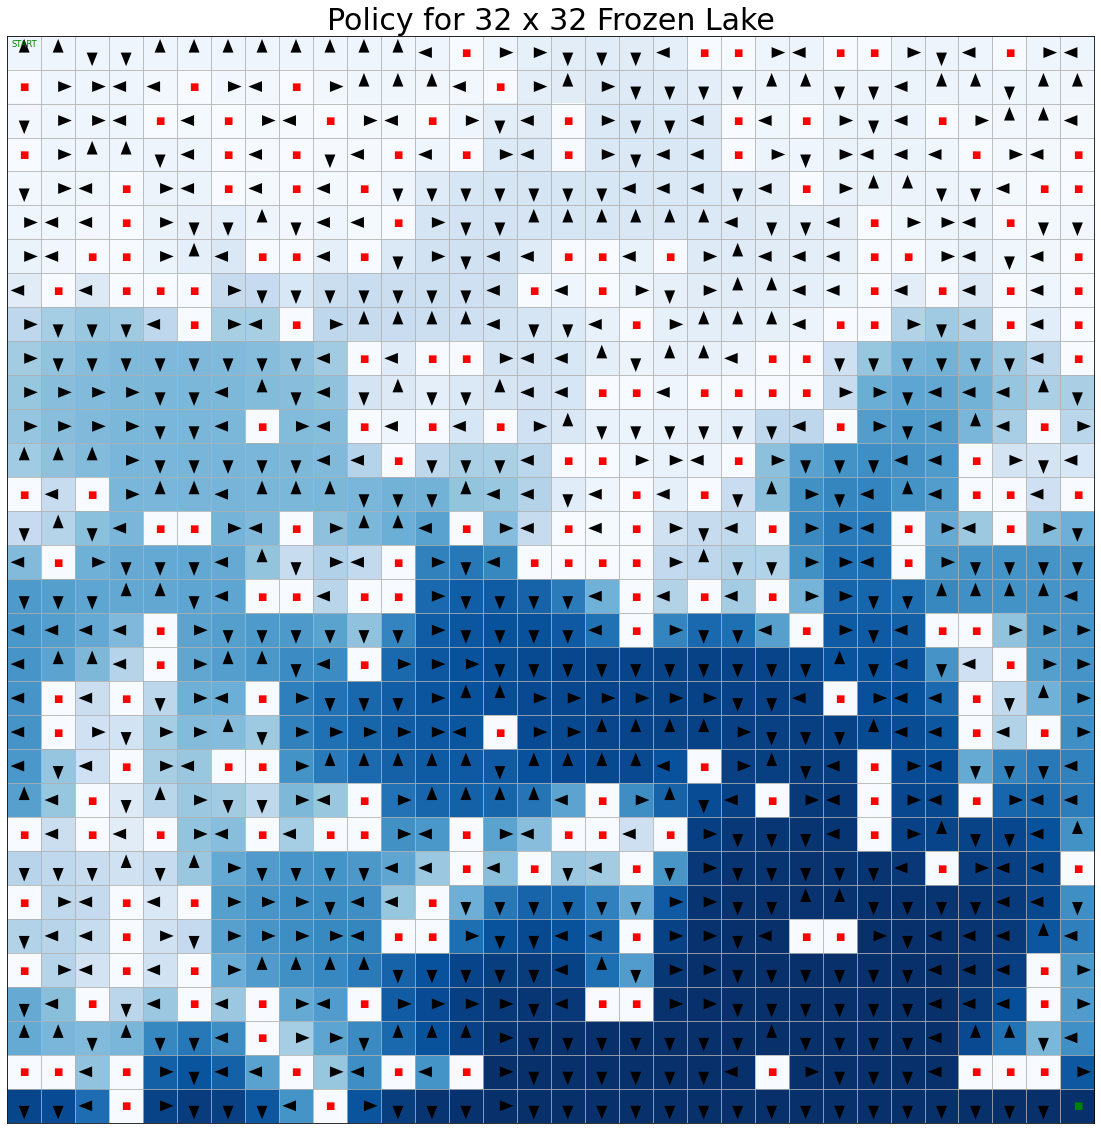

In [524]:
frzL = mdp.ValueIteration(T,R,0.9999)
frzL.run()
policy = np.asarray(frzL.policy).reshape(map_size,map_size)
value = np.asarray(frzL.V).reshape(map_size,map_size)

x,y = np.meshgrid(np.linspace(1,len(policy),len(policy)),np.linspace(1,len(policy),len(policy)))
u,v = np.meshgrid(np.linspace(1,len(policy),len(policy)),np.linspace(1,len(policy),len(policy)))

fig = plt.figure(figsize=(20,20))

for i in range(0,len(policy)):
    for j in range(0,len(policy)):
        n = len(policy)-1
        col = policy[i][j]
        if lake[i][j] == "H":
            plt.text(j+1,i+1,"■",color="red",horizontalalignment='center',verticalalignment='center')
            u[i][j] = 0
            v[i][j] = 0
        elif lake[i][j] == "G":
            plt.text(j+1,i+1,"■",color="green",horizontalalignment='center',verticalalignment='center')
            u[i][j] = 0
            v[i][j] = 0
        elif col == 0:
            u[i][j] = -1
            v[i][j] = 0
        elif col == 1:
            u[i][j] = 0
            v[i][j] = -1
        elif col == 2:
            u[i][j] = 1
            v[i][j] = 0
        else:
            u[i][j] = 0
            v[i][j] = 1
    print()
    
value = np.asarray(frzL.V)
    
for i in range(0,32):
    value = np.insert(value,0,0)

for i in range(0,33):
    value = np.insert(value,32*i+i,0)
    
value = value.reshape(map_size+1,map_size+1)
plt.imshow(value,cmap="Blues")

plt.text(1,0.6,"START",color="green",horizontalalignment='center',verticalalignment='top',fontsize='small',figure=fig)
plt.quiver(x,y,u,v,scale=80,headwidth=200,headlength=250,headaxislength=250,width=0.0005,figure=fig)
plt.grid(True,which='major')
plt.xticks(ticks=np.linspace(0.5,32.5,33),labels=None)
plt.yticks(ticks=np.linspace(0.5,32.5,33),labels=None)
plt.ylim(32.5,0.5)
plt.xlim(0.5,32.5)
plt.tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)
plt.title("Policy for 32 x 32 Frozen Lake",fontdict = {'fontsize' : 30})
plt.savefig("Images/FrozenLake32x32_policy.png")
plt.show()